<a href="https://colab.research.google.com/github/mostafa-ja/mal_adv3/blob/main/2_DNN_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader,WeightedRandomSampler
from sklearn.model_selection import train_test_split
from scipy import sparse
import gdown
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import time
import matplotlib.pyplot as plt

torch.manual_seed(0)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
download_links = ['https://github.com/mostafa-ja/mal_adv3/raw/main/data/X_redefined_sparse_matrix.npz',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/data/labels.pt',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/data/vocab.pkl',
]

In [3]:
output_filepath = '/content/'
for link in download_links:
  gdown.download(link, output_filepath)


Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/data/X_redefined_sparse_matrix.npz
To: /content/X_redefined_sparse_matrix.npz
100%|██████████| 2.31M/2.31M [00:00<00:00, 11.2MB/s]
Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/data/labels.pt
To: /content/labels.pt
100%|██████████| 517k/517k [00:00<00:00, 6.71MB/s]
Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/data/vocab.pkl
To: /content/vocab.pkl
100%|██████████| 9.18M/9.18M [00:00<00:00, 46.0MB/s]


In [4]:
def weight_sampler(labels_train):

    # count occurance of each class
    labels_train = labels_train.to(torch.int8)
    unique, counts = np.unique(labels_train.to(torch.int8), return_counts=True)

    # calcuate weight of each class
    class_weights = [1.0/c for c in counts]

    # assign weight to each sample
    sample_weights = [class_weights[i] for i in labels_train]

    # Create WeightedRandomSampler
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    return sampler

In [99]:
# Load dataset
X_redefined = sparse.load_npz("X_redefined_sparse_matrix.npz")
labels_tensor = torch.load('labels.pt')

# Split data into train, validation, and test sets with stratified sampling
X_train_val, X_test, labels_train_val, labels_test = train_test_split(X_redefined, labels_tensor, test_size=0.2, stratify=labels_tensor, random_state=42)
X_train, X_val, labels_train, labels_val = train_test_split(X_train_val, labels_train_val, test_size=0.2, stratify=labels_train_val, random_state=42)

# number of benigns and malicious sample in training dataset
n_ben = (labels_train.squeeze()== 0).sum().item()
n_mal = (labels_train.squeeze()== 1).sum().item()

# Combine features and labels into datasets
# we use dtype=torch.int8, for Memory-Efficient here, later we will convert to float
train_dataset = TensorDataset(torch.tensor(X_train.toarray(), dtype=torch.int8), labels_train)
val_dataset = TensorDataset(torch.tensor(X_val.toarray(), dtype=torch.int8), labels_val)
test_dataset = TensorDataset(torch.tensor(X_test.toarray(), dtype=torch.int8), labels_test)

# Define the DataLoader for training, validation, and test sets
batch_size = 256
sampler = weight_sampler(labels_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size,sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Clear unnecessary variables
#del X_redefined, labels_tensor, X_train_val, X_test, labels_train_val, labels_test, X_train, X_val, labels_train, labels_val

In [6]:
def plot_function(x1,x2):
    width =0.3
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    plt.bar(np.arange(1, len(x1)+1), x1, width=width)
    plt.bar(np.arange(1, len(x2)+1)+ width, x2, width=width)
    ax.legend(labels=['Class 0', 'Class 1'])
    plt.show()

total number of label ones 41306
total number of label zeros 41262


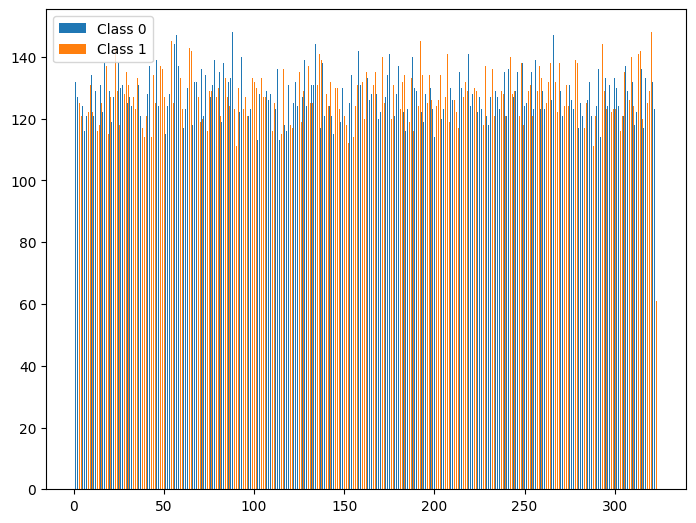

In [7]:
# iterate through dataset and plot class distribution in each batch
zeros = []
ones = []
for idx, (x,y) in enumerate(train_loader):
    unique, counts = np.unique(y.numpy(), return_counts=True)
    zeros.append(counts[0])
    ones.append(counts[1])

print('total number of label ones',sum(ones))
print('total number of label zeros',sum(zeros))
plot_function(zeros,ones)

-----------------------------------------
Epoch 1
Proportion of seen benign samples: 0.4072
Proportion of seen malicious samples: 1.0000
-----------------------------------------
Epoch 2
Proportion of seen benign samples: 0.6483
Proportion of seen malicious samples: 1.0000
-----------------------------------------
Epoch 3
Proportion of seen benign samples: 0.7915
Proportion of seen malicious samples: 1.0000
-----------------------------------------
Epoch 4
Proportion of seen benign samples: 0.8765
Proportion of seen malicious samples: 1.0000
-----------------------------------------
Epoch 5
Proportion of seen benign samples: 0.9269
Proportion of seen malicious samples: 1.0000
-----------------------------------------
Epoch 6
Proportion of seen benign samples: 0.9556
Proportion of seen malicious samples: 1.0000
-----------------------------------------
Epoch 7
Proportion of seen benign samples: 0.9737
Proportion of seen malicious samples: 1.0000
-----------------------------------------

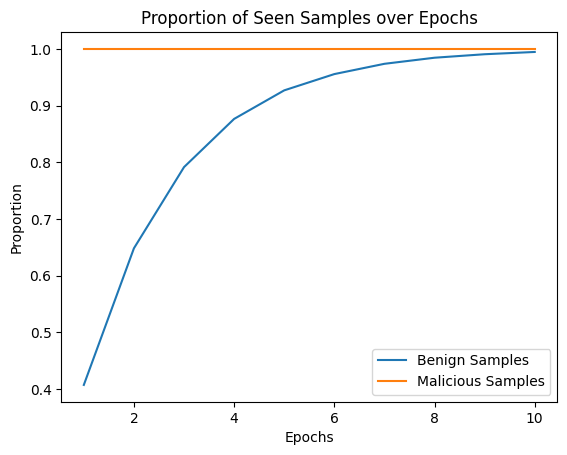

In [109]:
benign_set = set()
malicious_set = set()

proportions_benign = []
proportions_malicious = []


for epoch in range(10):
    for batch_indices in train_loader.batch_sampler:
        for idx in batch_indices:
            label = train_dataset[idx][1].item()
            if label == 0:
                benign_set.add(idx)
            else:
                malicious_set.add(idx)

    # Calculate proportions
    proportion_benign = len(benign_set) / n_ben
    proportion_malicious = len(malicious_set) / n_mal

    proportions_benign.append(proportion_benign)
    proportions_malicious.append(proportion_malicious)

    print('-----------------------------------------')
    print(f'Epoch {epoch+1}')
    print(f'Proportion of seen benign samples: {proportion_benign:.4f}')
    print(f'Proportion of seen malicious samples: {proportion_malicious:.4f}')

# Plot
epochs = range(1, 11)
plt.plot(epochs, proportions_benign, label='Benign Samples')
plt.plot(epochs, proportions_malicious, label='Malicious Samples')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Proportion')
plt.title('Proportion of Seen Samples over Epochs')
plt.legend()

# Show plot
plt.show()

In [ ]:
class MalwareDetectionModel(nn.Module):
    def __init__(self, input_size=10000, hidden_1_size=200, hidden_2_size=200, num_labels=2, dropout_prob=0.6):
        super(MalwareDetectionModel, self).__init__()

        self.input_size = input_size
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.num_labels = num_labels
        self.dropout_prob = dropout_prob

        self.fc1 = nn.Linear(input_size, hidden_1_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_1_size, hidden_2_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_2_size, num_labels)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.log_softmax(x)
        return x


In [ ]:
model = MalwareDetectionModel()
model = model.to(device)
model

MalwareDetectionModel(
  (fc1): Linear(in_features=10000, out_features=200, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.6, inplace=False)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=200, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)

In [ ]:
def adjust_learning_rate(optimizer, epoch, lr_step=(20,30,40), lr_decay_ratio=0.2):
    """Adjust the learning rate based on the epoch number."""
    if epoch == 0:
        optimizer.param_groups[0]['lr'] /= 8
    elif epoch in [1, 2, 3]:  # in step five , we finish warm up ,and start normal learning rate
        optimizer.param_groups[0]['lr'] *= 2
    if epoch in lr_step: # in these steps , we are geting close to optimal point so we need to have shorter step
        optimizer.param_groups[0]['lr'] *= lr_decay_ratio
    return optimizer


In [ ]:
learning_rate = 0.001
weight_decay = 0.
num_epochs = 50
dropout = 0.6

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

best_f1_score = 0.
best_epoch = 0
total_time = 0.
nbatches = len(train_loader)

for i in range(num_epochs):
    model.train()
    losses, f1_scores = [], []
    optimizer = adjust_learning_rate(optimizer, i)

    for idx_batch, (x_train, y_train) in enumerate(train_loader):
        x_train, y_train = x_train.to(torch.float32).to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss_train = criterion(outputs, y_train.view(-1).long())
        loss_train.backward()
        optimizer.step()

        predicted = (outputs.argmax(1)).unsqueeze(1)
        f1_train = f1_score(y_train.cpu().numpy(), predicted.cpu().numpy())

        losses.append(loss_train.item())
        f1_scores.append(f1_train)

    model.eval()
    avg_f1_val = []

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(torch.float32).to(device), y_val.to(device)
            outputs = model(x_val)
            predicted = (outputs.argmax(1)).unsqueeze(1)
            f1_val = f1_score(y_val.cpu().numpy(), predicted.cpu().numpy())
            avg_f1_val.append(f1_val)

    avg_f1_val = np.mean(avg_f1_val)

    if avg_f1_val >= best_f1_score:
        best_f1_score = avg_f1_val
        best_epoch = i
        torch.save(model.state_dict(), 'model_DNN.pth')

    print(f'Epoch: {i+1}/{num_epochs} | Training loss: {np.mean(losses):.4f} | Validation F1-score: {avg_f1_val:.4f} | The best validation F1-score: {best_f1_score * 100:.2f} at epoch: {best_epoch+1}')

print(f'Best F1-score: {best_f1_score:.4f} | Best Epoch: {best_epoch+1}')


Epoch: 1/50 | Training loss: 0.2776 | Validation F1-score: 0.7793 | The best validation F1-score: 77.93 at epoch: 1
Epoch: 2/50 | Training loss: 0.0538 | Validation F1-score: 0.9049 | The best validation F1-score: 90.49 at epoch: 2
Epoch: 3/50 | Training loss: 0.0262 | Validation F1-score: 0.9106 | The best validation F1-score: 91.06 at epoch: 3
Epoch: 4/50 | Training loss: 0.0229 | Validation F1-score: 0.9256 | The best validation F1-score: 92.56 at epoch: 4
Epoch: 5/50 | Training loss: 0.0159 | Validation F1-score: 0.9220 | The best validation F1-score: 92.56 at epoch: 4
Epoch: 6/50 | Training loss: 0.0141 | Validation F1-score: 0.9178 | The best validation F1-score: 92.56 at epoch: 4
Epoch: 7/50 | Training loss: 0.0138 | Validation F1-score: 0.9168 | The best validation F1-score: 92.56 at epoch: 4
Epoch: 8/50 | Training loss: 0.0107 | Validation F1-score: 0.9196 | The best validation F1-score: 92.56 at epoch: 4
Epoch: 9/50 | Training loss: 0.0123 | Validation F1-score: 0.9226 | The 

In [ ]:
# Load model parameters
model_DNN = MalwareDetectionModel().to(device)
model_DNN.load_state_dict(torch.load('model_DNN.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
def model_evaluation(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():
        for X_batch, labels_batch in test_loader:
            X_batch, labels_batch = X_batch.to(torch.float32).to(device), labels_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.topk(outputs, k=1)
            predictions.extend(predicted.tolist())
            true_labels.extend(labels_batch.tolist())

    # Convert predictions and true labels to numpy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Calculate and print test accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Test Accuracy: {accuracy:.4f}')

    # Calculate and print precision, recall, and F1-score
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

    # Calculate and print true positives, true negatives, false positives, and false negatives
    TP = ((predictions == 1) & (true_labels == 1)).sum()
    TN = ((predictions == 0) & (true_labels == 0)).sum()
    FP = ((predictions == 1) & (true_labels == 0)).sum()
    FN = ((predictions == 0) & (true_labels == 1)).sum()

    print(f'True Positives (TP): {TP}')
    print(f'True Negatives (TN): {TN}')
    print(f'False Positives (FP): {FP}')
    print(f'False Negatives (FN): {FN}')

    # Calculate and print False Negative Rate (FNR) and False Positive Rate (FPR)
    FNR = FN / (FN + TP)
    FPR = FP / (FP + TN)

    print(f'False Negative Rate (FNR): {FNR:.4f}')
    print(f'False Positive Rate (FPR): {FPR:.4f}')


In [ ]:
model_evaluation(model_DNN,test_loader,device=device)

Test Accuracy: 0.9934
Precision: 0.9410
Recall: 0.9038
F1-score: 0.9220
True Positives (TP): 1005
True Negatives (TN): 24628
False Positives (FP): 63
False Negatives (FN): 107
False Negative Rate (FNR): 0.0962
False Positive Rate (FPR): 0.0026


In [ ]:
#here , we define prediction, as probability(not binary)

# Evaluate the trained model on the test set
model.eval()  # Set the model to evaluation mode
predictions = []
true_labels = []

with torch.no_grad():
    for X_batch, labels_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.topk(outputs, k=1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels_batch.tolist())

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)


# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(true_labels, predictions)

# Calculate F1-score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes the F1-score
best_f1_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = np.max(f1_scores)

print(f'Best F1-score: {best_f1_score:.4f} at threshold: {best_f1_threshold:.4f}')


Best F1-score: 0.9200 at threshold: 1.0000


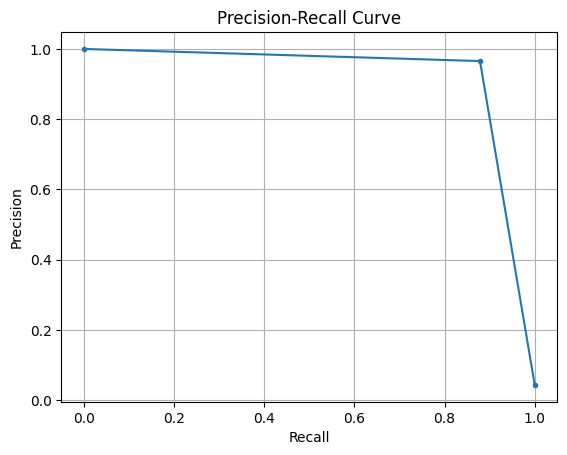

In [ ]:

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(true_labels, predictions)

# Plot precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


In [ ]:
# Compute fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(true_labels, predictions)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()